In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)
plt.style.use('dark_background')

In [2]:
import optax
import jax.numpy as jnp
from jax import random, nn, grad, lax

import numpyro.distributions as dist
from numpyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal, AutoMultivariateNormal

In [3]:
seed = 2982666625879488464
rng_key = random.PRNGKey(seed)

D = 100
N = 100

rng_key, _rng_key = random.split(rng_key)
X = random.normal(_rng_key, shape=(N, D))

y = X @ nn.one_hot(0, num_classes=D) + random.normal(_rng_key, shape=(N,))

In [4]:
from models import exact_blr, BayesRegression

mu_n, P_n, a_n, b_n = exact_blr(X, y)

L_n = jnp.linalg.inv(jnp.linalg.cholesky(P_n))

rng_key, _rng_key = random.split(rng_key)
sigma_square = dist.InverseGamma(a_n, b_n).sample(_rng_key, sample_shape=(1000,))

rng_key, _rng_key = random.split(rng_key)
eps = jnp.expand_dims(jnp.sqrt(sigma_square), -1) * random.normal(_rng_key, shape=(1000, D))
betas = mu_n + eps @ L_n.T

0.10123982 0.014317473


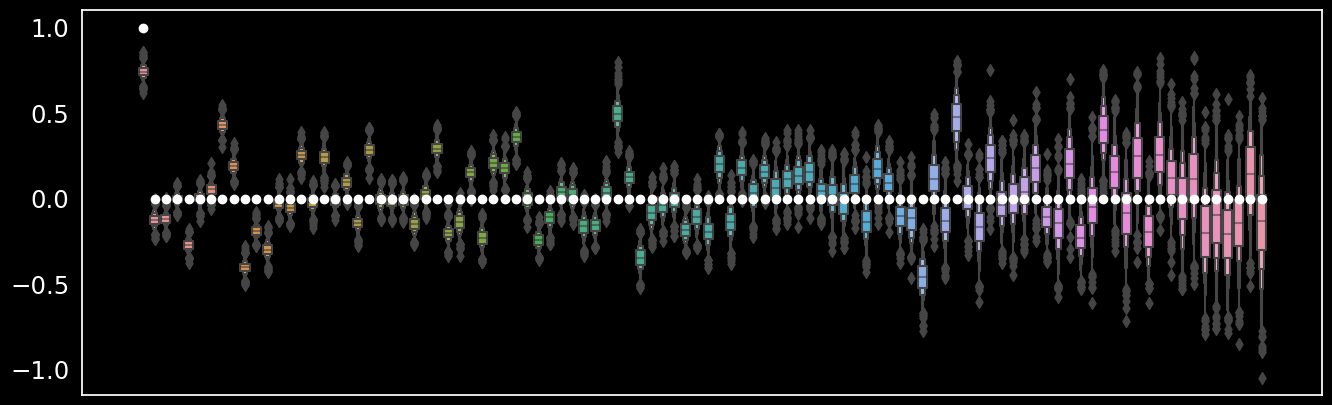

In [5]:
print( b_n/(a_n - 1), b_n/ jnp.sqrt((a_n-1)**2 * (a_n - 2)) )

plt.figure(figsize=(16, 5))
sns.boxenplot(betas);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);

In [6]:
rng_key, _rng_key = random.split(rng_key)

bayes_reg = BayesRegression(_rng_key, X)
samples = bayes_reg.fit(y, num_samples=250, warmup_steps=500, num_chains=4)

sample: 100%|██████████| 750/750 [00:19<00:00, 39.12it/s]


0.804392 0.12291598


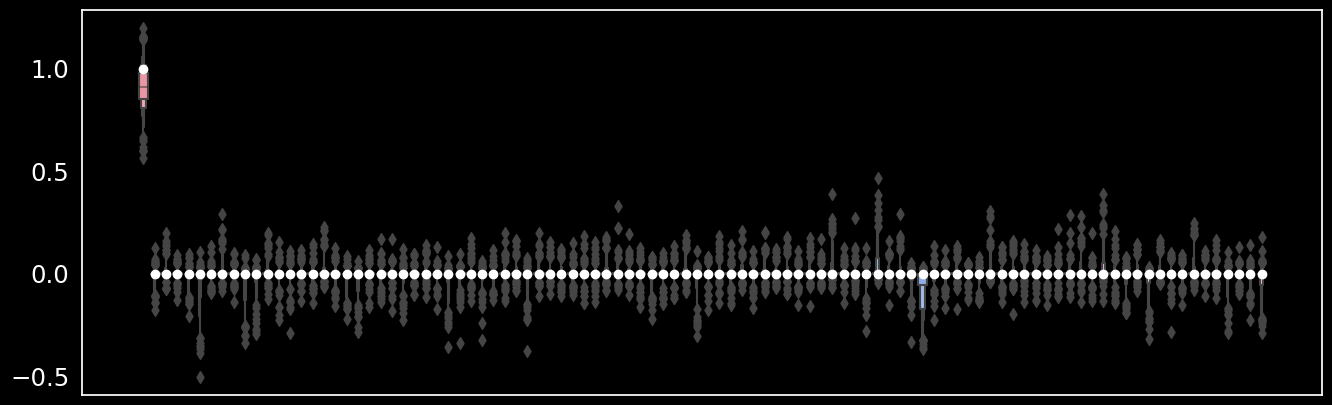

In [7]:
print( samples['sigma^2'].mean(0), samples['sigma^2'].std(0))

plt.figure(figsize=(16, 5))
sns.boxenplot(samples['beta']);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);

100%|██████████| 1000/1000 [00:01<00:00, 548.17it/s, init loss: 1081.9258, avg. loss [951-1000]: 205.9362]


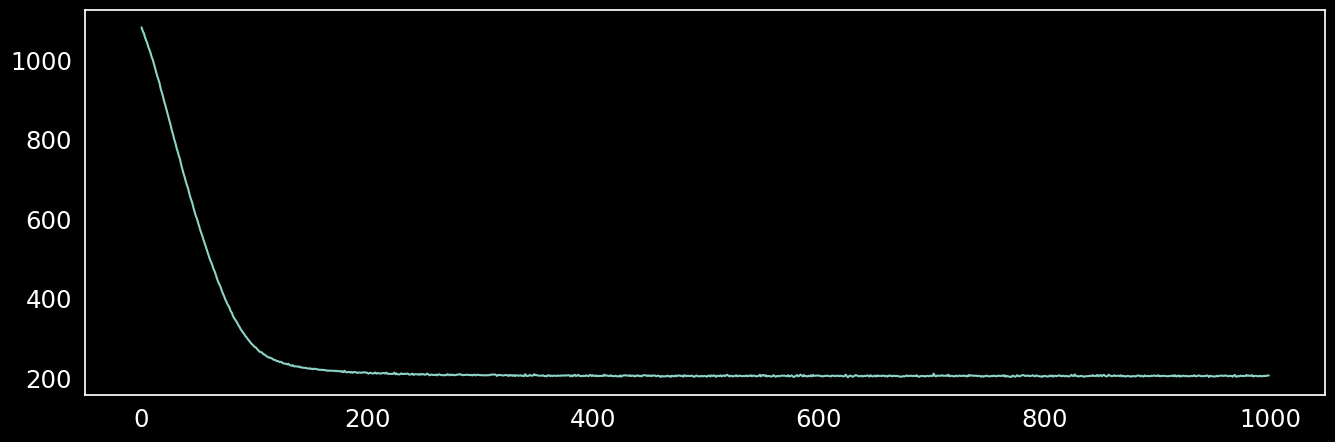

In [8]:
from models import BayesRegressionSVI

rng_key, _rng_key = random.split(rng_key)
bayes_reg_svi = BayesRegressionSVI(_rng_key, X)

samples_svi, losses = bayes_reg_svi.fit(y, num_particles=100, autoguide='mean-field')

plt.figure(figsize=(16, 5))
plt.plot(losses)

1.65852 0.12291598


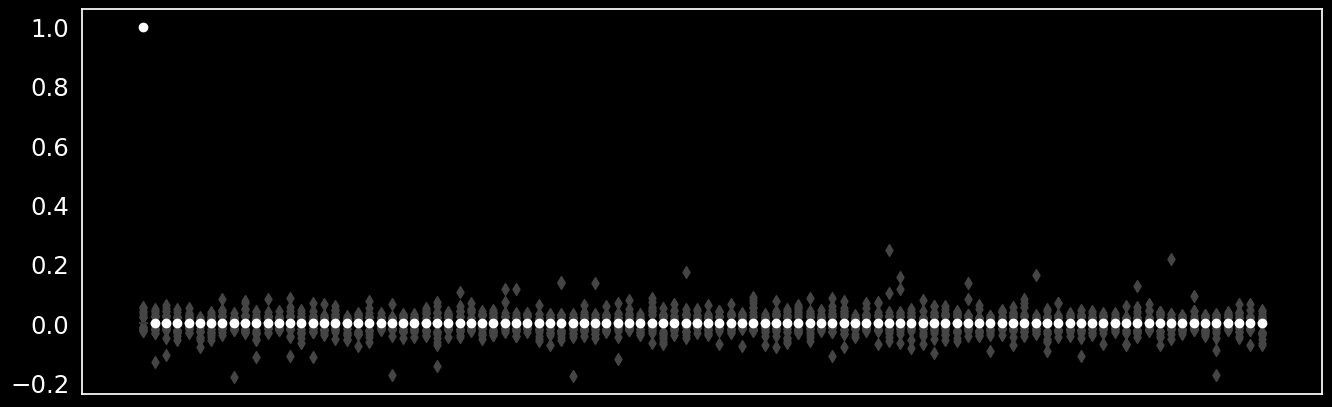

In [9]:
print( jnp.square(samples_svi['sigma']).mean(0), jnp.square(samples['sigma']).std(0))

plt.figure(figsize=(16, 5))
sns.boxenplot(samples_svi['beta']);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);

100%|██████████| 1000/1000 [00:01<00:00, 823.11it/s, init loss: 1069.1747, avg. loss [951-1000]: 195.6257]


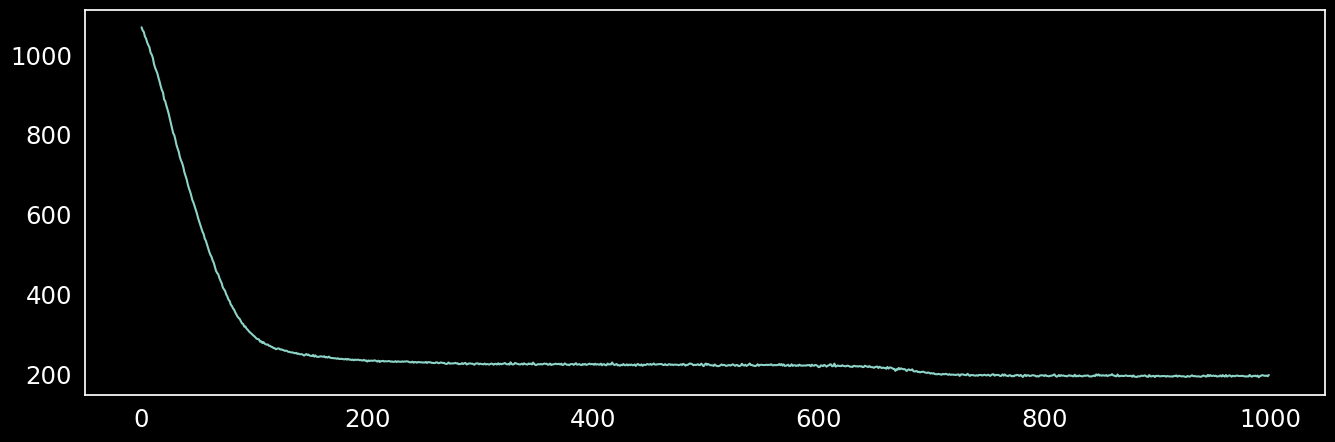

In [10]:
samples_svi, losses = bayes_reg_svi.fit(y, num_particles=100, autoguide='multivaraite')

plt.figure(figsize=(16, 5))
plt.plot(losses)

0.8435907 0.12291598


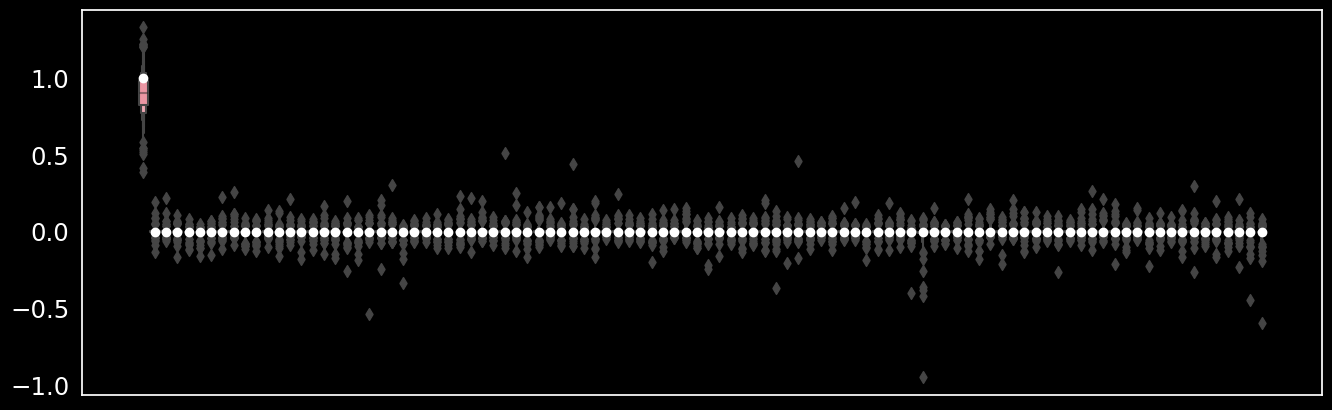

In [11]:
print( jnp.square(samples_svi['sigma']).mean(0), jnp.square(samples['sigma']).std(0))

plt.figure(figsize=(16, 5))
sns.boxenplot(samples_svi['beta']);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);

Let us consider the following linear regression problem
$$ y  = \pmb{\theta} \cdot \pmb{X} + \epsilon $$
$$ \epsilon \sim \mathcal{N}(0, \sigma^2)$$
$$ p(\theta_i|\sigma^2) = \mathcal{N}\left(0, \sigma^2 \right)$$
$$ p(\sigma^{2}) = \mathcal{\Gamma}^{-1}\left(2, 1 \right)$$

Given some data $\mathcal{D} = \left(y_1, \ldots, y_T\right) \equiv \pmb{y}$ the posterior $p(\pmb{\theta}|\mathcal{D})$ becomes

\begin{equation}
    \begin{split}
        p\left(\pmb{\theta}| \mathcal{D}, \sigma^2 \right) &= \mathcal{N}\left(\pmb{\mu}_n, \sigma^2 \pmb{P}_n^{-1} \right) \\
        \pmb{\mu}_n &= \pmb{P}^{-1}_n \pmb{X}^T \pmb{y}\\
        \pmb{P}_n &= \pmb{I} + \pmb{X}^T \pmb{X} \\
        p(\sigma^2|\mathcal{D}) &= \mathcal{\Gamma}^{-1}(a_n, b_n) \\
        a_n &= 2 + \frac{n}{2} \\
        b &= 1 + \frac{\pmb{y}^T\pmb{y} - \pmb{\mu}^T_n  P_n \pmb{\mu}_n }{2} 
    \end{split}
\end{equation}

Our reduced posterior over coeficients $\pmb{\theta}$ will have the following form 
$$ \tilde{p}(\theta_i|\sigma^2) = \mathcal{N}\left( 0, \gamma_i^2 \sigma^2 \right), \qquad \gamma_i^2 = \frac{\tau_0^2\tau^2\lambda_i^2}{1 + \tau_0^2\tau^2\lambda_i^2}$$
where $\tau^2 \lambda_i^2 \geq 0$. The change in the variational free energy is obtained as 

$$ \Delta F = \ln E_{Q(\pmb{\theta}, \sigma^2)}\left[ \frac{\tilde{p}(\pmb{\theta}|\sigma^2)}{p(\pmb{\theta}|\sigma^2)}\right] = - a_n \ln \left(1 + \frac{m_n}{2 b_n} \right) + \ln | \pmb{G} | + \frac{1}{2}(\ln |\pmb{P}_n| - \ln|\pmb{I} + \pmb{G}\pmb{X}^T\pmb{X}|)$$
where $ \pmb{G} = diag(\pmb{\gamma}^2)$, and
$$m_n = \pmb{\mu}_n^T \pmb{P}_n \left(\pmb{G}\pmb{X}^T\pmb{X} + \pmb{I} \right)^{-1} \left( I - \pmb{G} \right) \pmb{\mu}_n $$


After maximisation of $\Delta F$ with respect to $\tau, \pmb{\lambda}$ we obtain the reduced posterior as
\begin{equation}
    \begin{split}
        \tilde{p}\left(\pmb{\theta}| \mathcal{D}, \sigma^2 \right) &= \mathcal{N}\left(\tilde{\pmb{\mu}}_n, \sigma^2 \tilde{\pmb{P}}^{-1}_n \right) \\
        \tilde{\pmb{\mu}}_n &= \tilde{\pmb{P}}^{-1}_n \pmb{X}^T \pmb{y}\\
        \tilde{\pmb{P}}_n &= \left(\bar{\pmb{G}}^{-1} + \pmb{X}^T \pmb{X}\right) \\
        \tilde{p}(\sigma^2|\mathcal{D}) &= \mathcal{\Gamma}^{-1}(\tilde{a}_n, \tilde{b}_n) \\
        \tilde{a} &= 2 + \frac{n}{2} \\
        \tilde{b} &= 1 + \frac{\pmb{y}^T\pmb{y} - \tilde{\pmb{\mu}}^T \tilde{P}_n \tilde{\pmb{\mu}} }{2} 
    \end{split}
\end{equation}

100%|██████████| 1000/1000 [00:02<00:00, 357.63it/s, init loss: 617.9220, avg. loss [951-1000]: -40.2327]


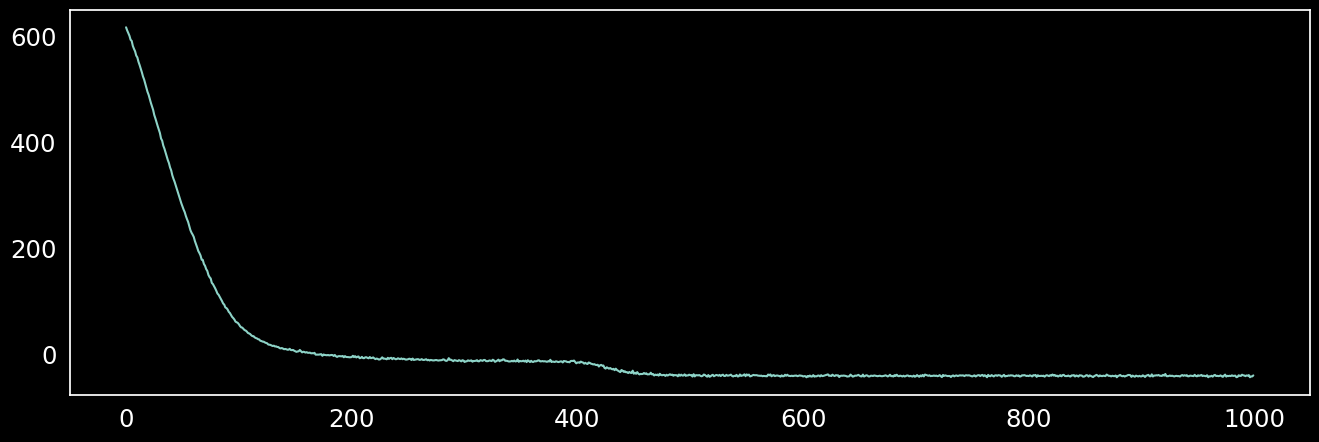

In [12]:
from models import BMRNormalRegression

rng_key, _rng_key = random.split(rng_key)
bmr_reg = BMRNormalRegression(_rng_key, X)

samples_bmr, losses = bmr_reg.fit(y, num_particles=100, autoguide='mean-field')

plt.figure(figsize=(16, 5))
plt.plot(losses)

0.78389853 0.12889534


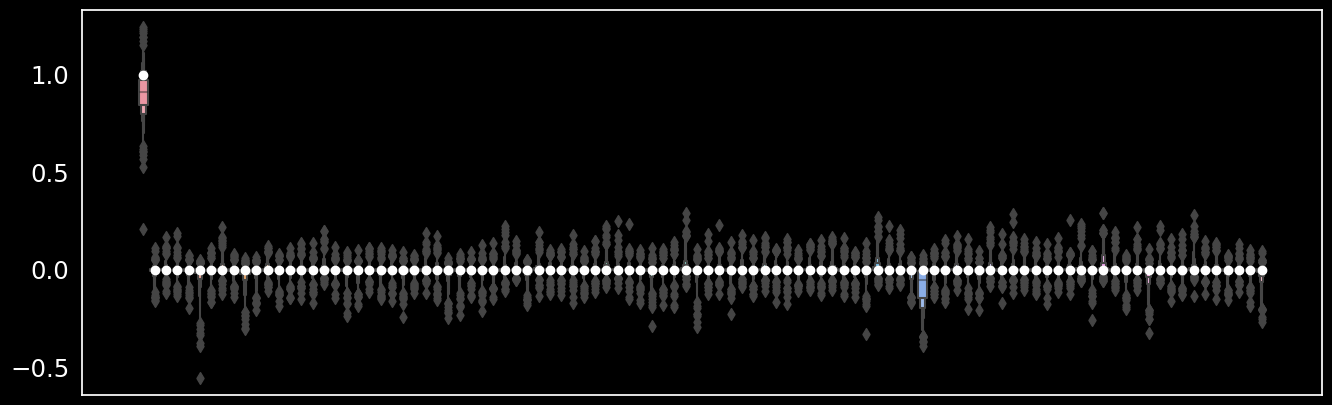

In [15]:
print(samples_bmr['sigma^2'].mean(0), samples_bmr['sigma^2'].std(0))

plt.figure(figsize=(16, 5))
sns.boxenplot(samples_bmr['beta']);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);

100%|██████████| 1000/1000 [00:02<00:00, 362.35it/s, init loss: 595.1731, avg. loss [951-1000]: -31.8009]


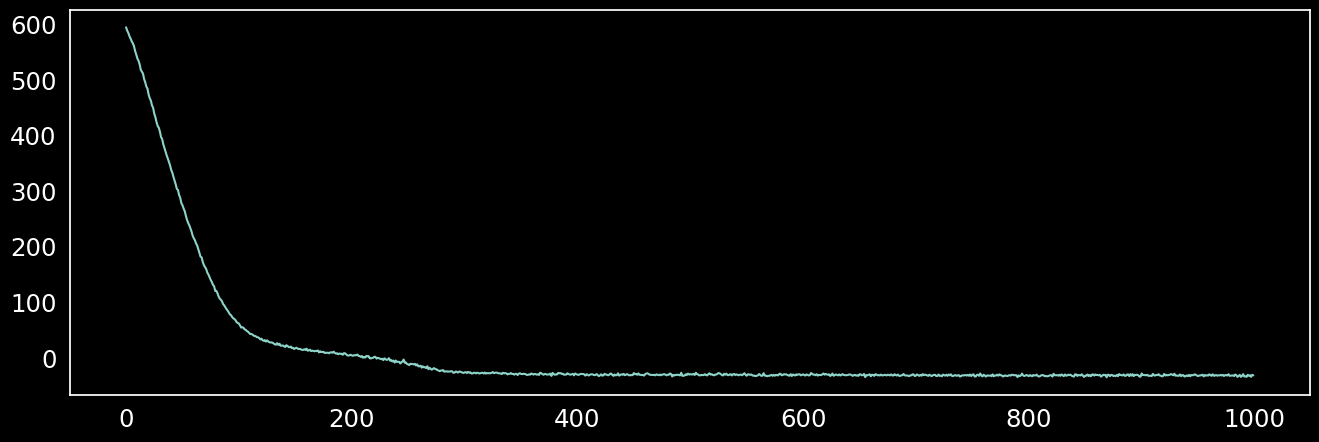

In [16]:
samples_bmr, losses = bmr_reg.fit(y, num_particles=100, autoguide='multivariate')

plt.figure(figsize=(16, 5))
plt.plot(losses)

0.7816892 0.13045967


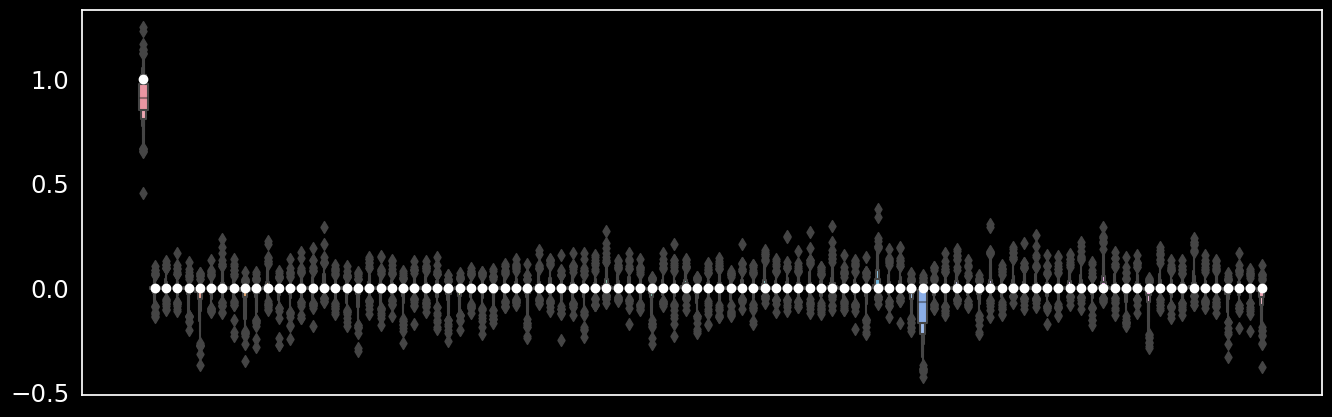

In [17]:
print(samples_bmr['sigma^2'].mean(0), samples_bmr['sigma^2'].std(0))

plt.figure(figsize=(16, 5))
sns.boxenplot(samples_bmr['beta']);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);

100%|██████████| 1000/1000 [00:02<00:00, 337.25it/s, init loss: 588.4152, avg. loss [951-1000]: -40.7331]


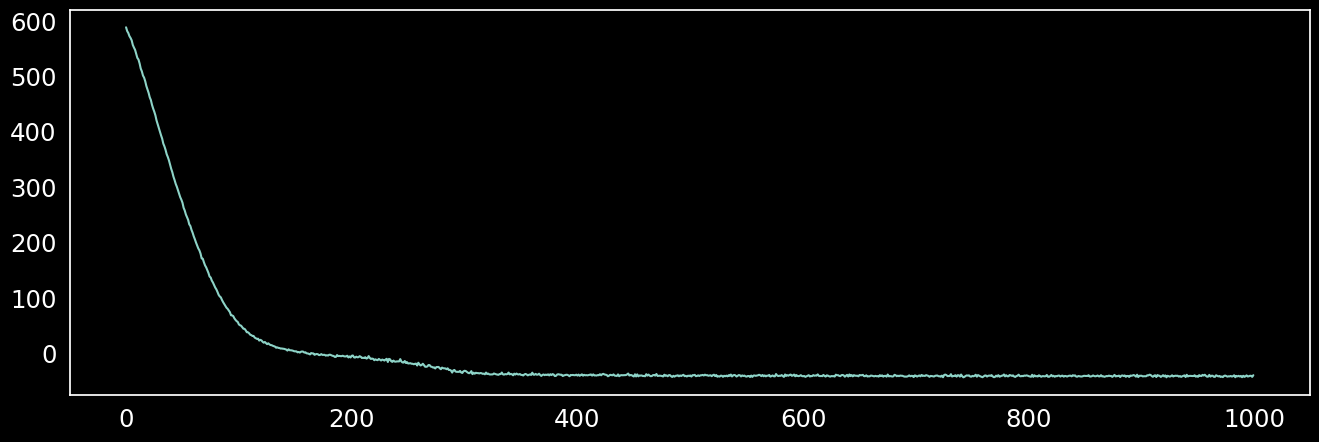

In [18]:
samples_bmr, losses = bmr_reg.fit(y, num_particles=100, autoguide='lowrank-multivariate')

plt.figure(figsize=(16, 5))
plt.plot(losses)

0.795335 0.13187067


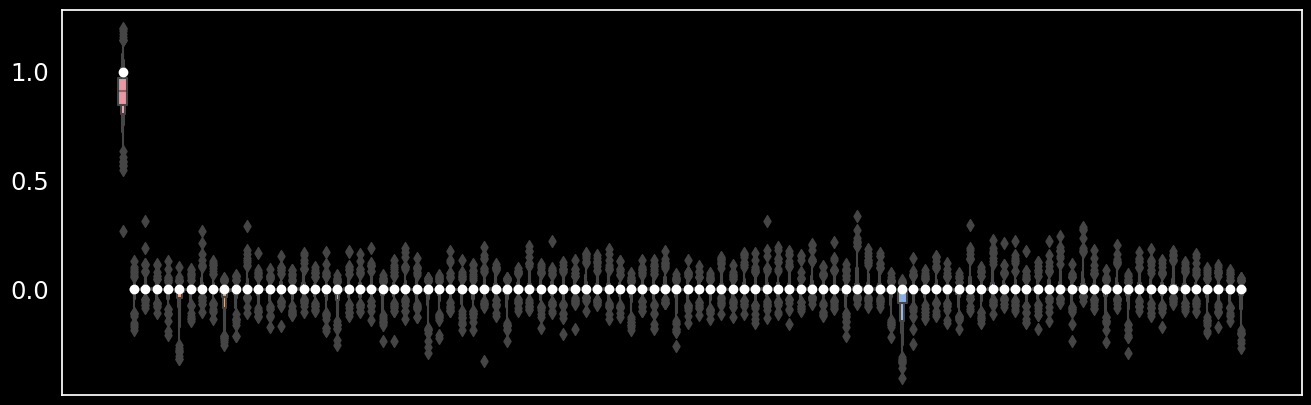

In [19]:
print(samples_bmr['sigma^2'].mean(0), samples_bmr['sigma^2'].std(0))

plt.figure(figsize=(16, 5))
sns.boxenplot(samples_bmr['beta']);
plt.plot(nn.one_hot(0, num_classes=D), 'wo');
plt.xticks(ticks=[]);